In [11]:
import glob
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import gaussian, threshold_minimum
from skimage.color import rgb2gray
from skimage.morphology import binary_opening, binary_closing
from skimage.measure import label, regionprops

from prettytable import PrettyTable
from collections import Counter

In [12]:
from skimage.filters import gaussian, threshold_minimum
from skimage.color import rgb2gray
from skimage.morphology import binary_opening, binary_closing
from skimage.measure import label, regionprops

class Executor():
    def __init__(self, door_img_path):
        self.door_img = cv2.imread(door_img_path)
        self.distance_to_gitar = 1.3
        self.distance_to_door = 2
        
        self.ratio = self.distance_to_gitar / self.distance_to_door
        
    def run(self, img_path, plot=False):
        img = cv2.imread(img_path)
        wg, hg = self._get_gitar(img, plot)
        wd, hd = self._get_door(img, plot)
        
        new_wg = self.ratio * wg
        new_hg = self.ratio * hg
        
        if (wd > new_wg) & (hd > new_hg):
            result = True
        else:
            result = False
        
        if plot:
            print('Пройдет' if result else 'Не пройдет')
        
        return result
    
    def _get_largest_component(self, mask):
        labels = label(mask) # разбиение маски на компоненты связности
        props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
        areas = [prop.area for prop in props] # нас интересуют площади компонент связности

        largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью

        return labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

    def _get_gitar(self, img, plot=False):
        img_blur = gaussian(img, sigma=0.5, multichannel=True)
        img_blur_gray = rgb2gray(img_blur)
        thresh_min = threshold_minimum(img_blur_gray)
        res_min = img_blur_gray <= thresh_min

        res_min = binary_opening(res_min, selem=np.ones((7, 7)))

        res_min = binary_closing(res_min, selem=np.ones((7, 7)))

        res = self._get_largest_component(res_min)
        
        if plot:
            plt.imshow(res, cmap='gray')
            plt.show()

        idx = []
        for i, x in enumerate(res):
            if True in x:
                idx.append(i)

        h = np.max(idx)- np.min(idx)

        idx = []
        for i, x in enumerate(res.T):
            if True in x:
                idx.append(i)

        w = np.max(idx) - np.min(idx)

        return w, h
    
    def _get_door(self, img, plot):
        MIN_MATCH_COUNT = 10
        # Initiate SIFT detector
        sift = cv2.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(self.door_img,None)
        kp2, des2 = sift.detectAndCompute(img,None)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)
        # store all the good matches as per Lowe's ratio test.

        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        if len(good) > MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            h,w,d = self.door_img.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            
            if plot:
                img2 = cv2.polylines(img,[np.int32(dst)],True,(255,255,255),5, cv2.LINE_AA)
                plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
                plt.show()

            w = np.sum((dst[3, 0] - dst[0, 0]) ** 2) ** (1/2)
            h = np.sum((dst[1, 0] - dst[0, 0]) ** 2) ** (1/2)
            
            return w, h

        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        return None, None

In [13]:
executor = Executor(os.path.join('data', 'door.jpg'))

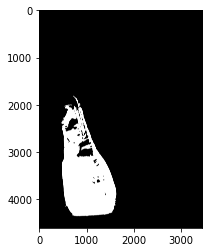

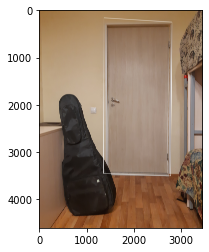

Пройдет


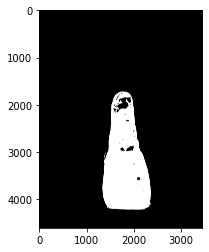

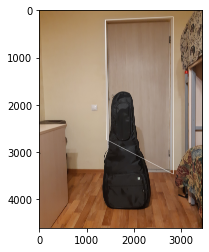

Пройдет


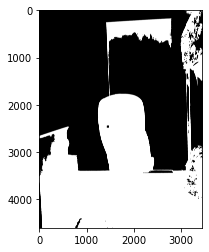

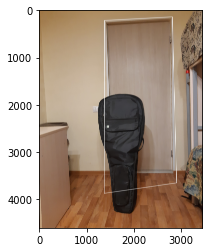

Не пройдет


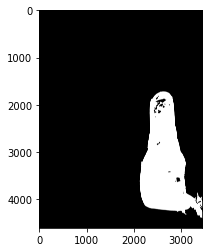

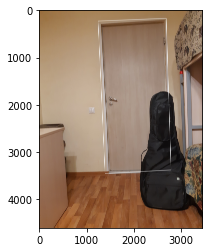

Пройдет


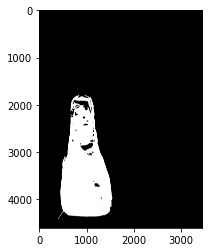

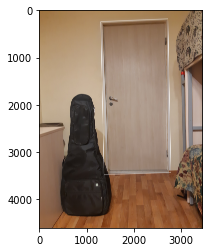

Пройдет


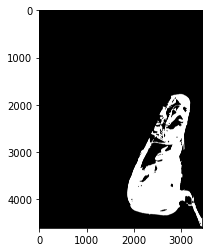

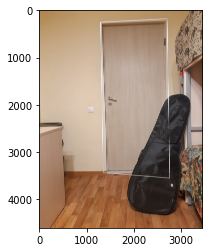

Пройдет


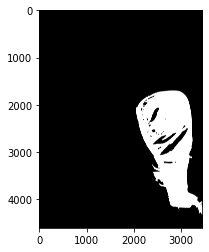

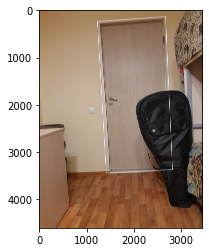

Пройдет


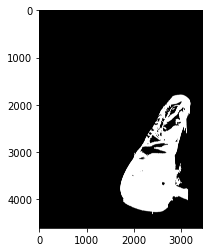

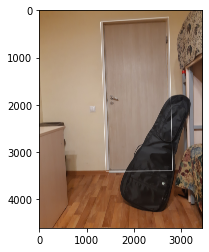

Пройдет


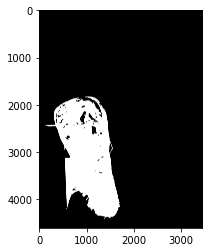

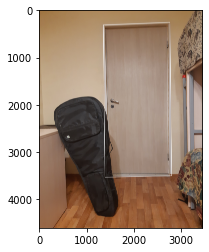

Пройдет


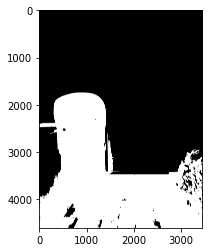

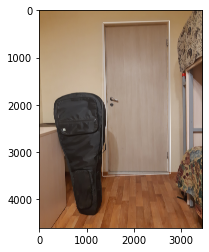

Не пройдет


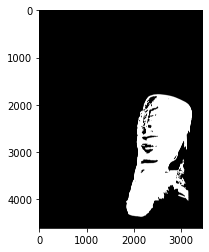

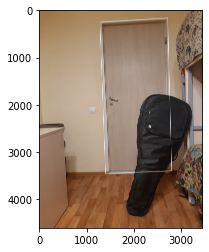

Пройдет


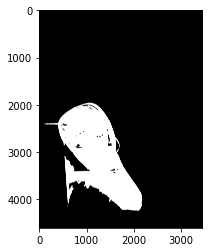

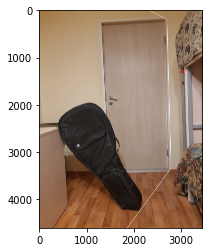

Пройдет


In [14]:
ims_positive = glob.glob(os.path.join('data', 'positive', '*.jpg'))

positive_results = []
for img in ims_positive:
    positive_results.append(executor.run(img, True))

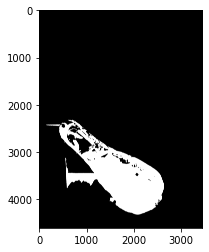

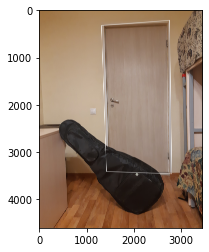

Не пройдет


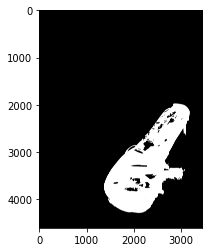

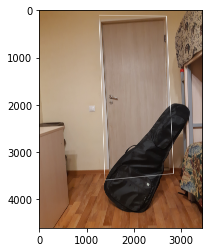

Пройдет


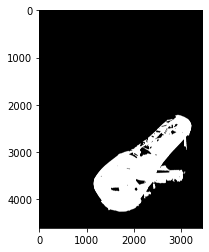

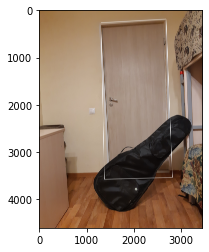

Пройдет


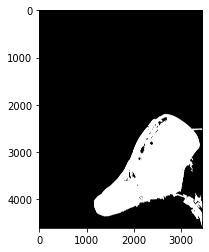

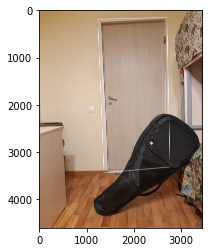

Не пройдет


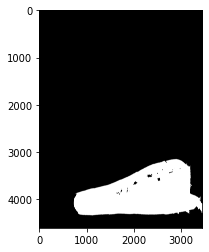

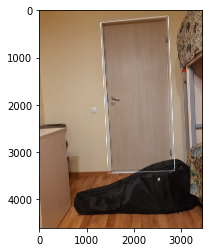

Не пройдет


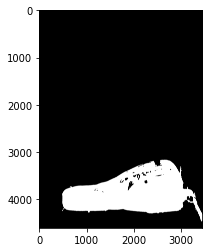

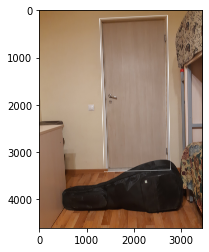

Не пройдет


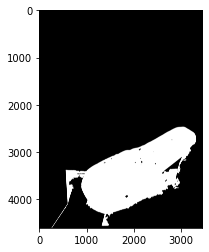

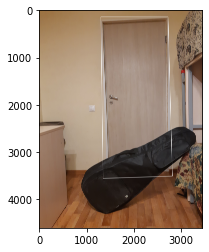

Не пройдет


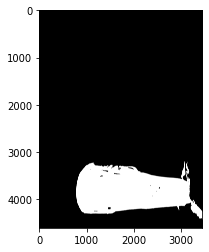

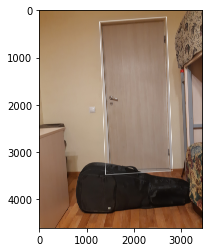

Не пройдет


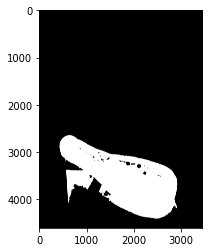

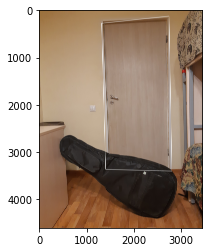

Не пройдет


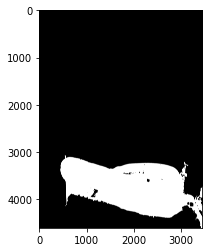

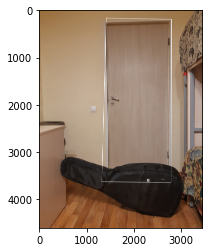

Не пройдет


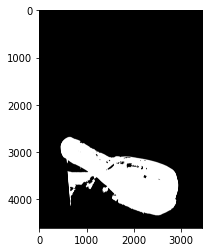

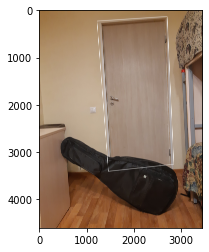

Не пройдет


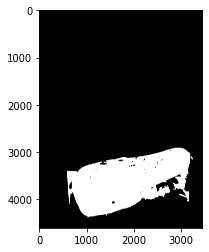

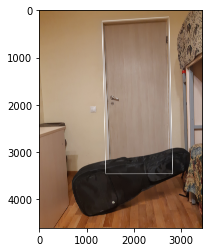

Не пройдет


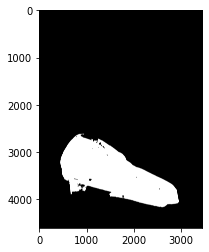

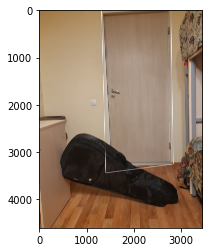

Не пройдет


In [8]:
ims_negative = glob.glob(os.path.join('data','negative', '*.jpg'))

negative_results = []
for img in ims_negative:
    negative_results.append(executor.run(img, True))

In [9]:
positive_counts = Counter(positive_results)
negative_counts = Counter(negative_results)

In [10]:
table = PrettyTable(['', 'True', 'False'])# creat table for results
table.add_row(['Positive', f'{positive_counts[True]}', f'{negative_counts[True]}'])
table.add_row(['Negative', f'{negative_counts[False]}', f'{positive_counts[False]}'])
print(table)

+----------+------+-------+
|          | True | False |
+----------+------+-------+
| Positive |  10  |   2   |
| Negative |  11  |   2   |
+----------+------+-------+
